## Document Vectors

In [28]:
import pandas as pd
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords
import random

import warnings
warnings.filterwarnings("ignore")

In [29]:
pd.set_option('display.max_colwidth', -1)

In [30]:
movie_lines_file = '../data/cornell-movie-dialogs/movie_lines.txt'

## Load the Movie Dialogs

In [31]:
with open(movie_lines_file) as f:
    movie_lines = [line.strip().split('+++$+++') for line in f.readlines()];

lines_df = pd.DataFrame([{'LineNumber': d[0].strip(), 
                                'Person': d[3].strip(),
                                'Line': d[4].strip(),
                                 'Movie' : d[2].strip()} 
                              for d in movie_lines])
lines_df = lines_df.set_index('LineNumber')

In [32]:
lines_df.head(10)

,Line,Movie,Person
LineNumber,,,
L1045,They do not!,m0,BIANCA
L1044,They do to!,m0,CAMERON
L985,I hope so.,m0,BIANCA
L984,She okay?,m0,CAMERON
L925,Let's go.,m0,BIANCA
L924,Wow,m0,CAMERON
L872,Okay -- you're gonna need to learn how to lie.,m0,BIANCA
L871,No,m0,CAMERON
L870,"I'm kidding. You know how sometimes you just become this ""persona""? And you don't know how to quit?",m0,BIANCA


In [33]:
len(lines_df)

304713

In [34]:
lines_df.nunique()

Line      265786
Movie     617   
Person    5356  
dtype: int64

In [35]:
lines_df_small = lines_df.head(30000)

In [36]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

def text_to_tokens(text):
    text = text.lower()
    text = remove_stopwords(text)
    tokens = simple_preprocess(text)
    return tokens

In [61]:
class DocumentDataset(object):
    
    def __init__(self, data:pd.DataFrame, column):
        document = data[column].apply(self.preprocess)
        self.documents = [ TaggedDocument( text, [index]) 
                          for index, text in document.iteritems() ]
      
    def preprocess(self, document):
        return preprocess_string(remove_stopwords(document))
        
    def __iter__(self):
        for document in self.documents:
            yield documents
            
    def tagged_documents(self, shuffle=False):
        if shuffle:
            random.shuffle(self.documents)
        return self.documents

In [62]:
documents_dataset = DocumentDataset(lines_df_small, 'Line')

## Document Vector Model

In [63]:
docVecModel = Doc2Vec(min_count=1, window=5, vector_size=100, sample=1e-4, negative=5, workers=8)
docVecModel.build_vocab(documents_dataset.tagged_documents())

In [64]:
docVecModel.train(documents_dataset.tagged_documents(shuffle=True),
            total_examples = docVecModel.corpus_count,
           epochs=50)

In [65]:
docVecModel.corpus_count

30000

In [66]:
docVecModel.save('../data/MovieLinesModel.d2v')

In [67]:
docVecModel = Doc2Vec.load('../data/MovieLinesModel.d2v')

In [68]:
docVecModel['L872']

array([-0.00776293,  0.00651885, -0.02034151, -0.01427365,  0.01622937,
        0.01621581, -0.02771013, -0.01889507,  0.03360317, -0.01611521,
        0.01630867, -0.00067029, -0.01025201, -0.03990042,  0.01759521,
        0.00090568, -0.0369111 ,  0.04621106, -0.02995945,  0.01865721,
        0.03433622,  0.00366057, -0.01253368,  0.05054632,  0.02500969,
       -0.01917591, -0.02947315, -0.03317001,  0.00370237,  0.01302342,
       -0.03007212, -0.00352953,  0.02180139,  0.02550646,  0.02334538,
        0.03114827, -0.02219468, -0.00838498,  0.00887686, -0.00665247,
       -0.0023828 , -0.02522203,  0.02204514, -0.01591336,  0.01578572,
       -0.05169064, -0.00062403,  0.00274801, -0.00359727, -0.02508221,
       -0.04327539, -0.02902433, -0.00465469, -0.00045784,  0.02146669,
        0.01180829, -0.01093275,  0.00606495,  0.00146907, -0.00592781,
        0.04368889, -0.03004531,  0.03038   , -0.00971382,  0.01195637,
       -0.02895789,  0.0288701 ,  0.01886206,  0.01791087, -0.01

In [69]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def show_image(vector, line):
    fig, ax = plt.subplots(1,1, figsize=(10, 2))
    ax.tick_params(axis='both', 
                   which='both',
                   left=False, 
                   bottom=False, 
                   top=False,
                   labelleft=False, 
                   labelbottom=False)
    ax.grid(False)
    print(line)
    ax.bar(range(len(vector)), vector, 0.5)
   
    
def show_movie_line(line_number):
    line = lines_df_small.ix[line_number].Line
    doc_vector = docVecModel.docvecs[line_number]
    show_image(doc_vector, line)
    

Okay -- you're gonna need to learn how to lie.


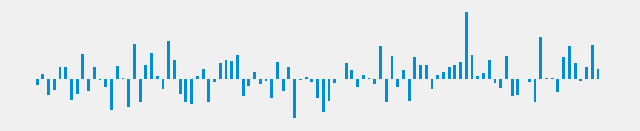

In [70]:
show_movie_line('L872')

In [71]:
docVecModel.docvecs.most_similar('L872')

[('L130961', 0.9898332357406616),
 ('L97075', 0.9897549152374268),
 ('L24549', 0.9896999001502991),
 ('L24315', 0.9895826578140259),
 ('L163066', 0.9891369938850403),
 ('L26725', 0.9890711903572083),
 ('L614', 0.9887322187423706),
 ('L172155', 0.9886608123779297),
 ('L31630', 0.9885237216949463),
 ('L721', 0.9884805679321289)]

In [72]:
docVecModel['L3246']

array([-0.06829467,  0.02242981, -0.05078856, -0.07035   ,  0.07722087,
        0.06660438, -0.07141703, -0.08858693,  0.12294995, -0.09882627,
        0.0724587 , -0.00671578, -0.01276152, -0.16027702,  0.05180485,
        0.01391566, -0.15666021,  0.18277358, -0.1519731 ,  0.0744875 ,
        0.1570174 , -0.02699648, -0.05171579,  0.20123765,  0.07372154,
       -0.09115686, -0.10226259, -0.17641462,  0.02879566,  0.05850007,
       -0.09071054, -0.06107473,  0.12881725,  0.07287296,  0.0642981 ,
        0.12309936, -0.07918996, -0.01871696,  0.03595861,  0.01402216,
       -0.03265442, -0.09588424,  0.0786329 , -0.04329152,  0.07008891,
       -0.23417503,  0.01702106,  0.01342677, -0.06705251, -0.08320943,
       -0.14190419, -0.1155156 , -0.01986075,  0.00190862,  0.08323323,
        0.05981447, -0.02909385,  0.04529011, -0.01379855, -0.01973556,
        0.18468383, -0.12745552,  0.141243  , -0.03622045,  0.04738159,
       -0.12672451,  0.15438148,  0.06275894,  0.02810842, -0.04

In [82]:
def to_vector(sentence):
    cleaned = preprocess_string(sentence)
    docVector = docVecModel.infer_vector(cleaned)
    return docVector

Okay -- you're gonna need to learn how to lie.


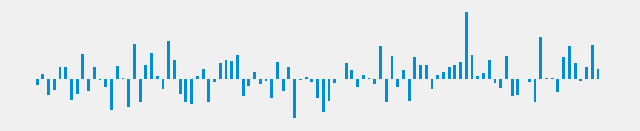

In [83]:
show_movie_line('L872')

you're gonna need to learn not to tell lies


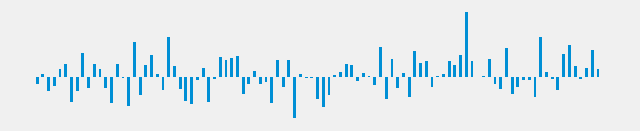

In [84]:
line = "you're gonna need to learn not to tell lies"
show_image(to_vector("you're gonna need to learn how to lie"), line)

In [86]:
def similar_movie_lines(sentence):
    vector = to_vector(sentence)
    similar_vectors = docVecModel.docvecs.most_similar(positive=[vector])
    similar_lines = [ lines_df.ix[line[0]].Line for line in similar_vectors]
    return similar_lines

similar_movie_lines("Sure, that's easy.  You gotta insult somebody.")

['Pack your shit! We gotta get outta here! We gotta get out!',
 "That goddamned woman. Thinks she can cart Jill off and leave me alone like this. I'm more than pissed, Margie. I'm a whole lot more than pissed. I been that plenty and I know the difference. This is different.",
 "Nah, he's nothin'. It's just sometimes... sometimes you just gotta punch somebody out, y'know?",
 "Ruined a brand-new pair of Lee Press- ons.  Well, I sat down for a beer and KA- BLEWEY! Next thing I know, somethin' blows through my kitchen window. Next thing I know, I'm ass up in Loretta's flower bed.",
 "Sure, that's easy.  You gotta insult somebody.",
 "That's no mystery. Julio and Paolo brought it in,  You don't want to hurt those boys, do you? I mean, they sure as Hell have got something coming, but it ain't what the Law wants to give them. You understand?  No. How could you understand.",
 "You?  Don't make me laugh.  You can't take care of shit.  You've been dicking me around since we started on this turd-

In [77]:
lines_df_small.ix['L59293'].Line

'Okay, ten thousand plus a G.E. toaster oven, a Litton microwave, a Cuisinart...'